# 1.0. Imports

In [9]:
import pandas as pd
import numpy as np
import math
import json
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

%matplotlib inline
plt.rcParams['figure.figsize'] = [25, 12]
plt.rcParams['font.size'] = 24
sns.set()

## 1.1. Data

In [10]:
# read in the json files\
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 2.0. Data Prepare

## 2.1. Portfolio

In [11]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [12]:
print(f'Number of rows: {portfolio.shape[0]}')
print(f'Number of columns: {portfolio.shape[1]}')

Number of rows: 10
Number of columns: 6


### 2.1.1. Transform Columns

In [13]:
def clean_channels(list_channels, portfolio=portfolio):
    """
    """
    df = portfolio
    
    for channel in list_channels:
        channel_name = f'c_{channel}'
        df[channel_name] = [1 if channel in row['channels'] else 0 for index, row in df.iterrows()]
    df = df.drop('channels', axis=1)
    
    return df

In [14]:
# Listing available channels
list_channels = ['web', 'email', 'mobile', 'social']

df_portfolio = clean_channels(list_channels)

### 2.1.2. Na Values

In [15]:
df_portfolio.isnull().sum()

reward        0
difficulty    0
duration      0
offer_type    0
id            0
c_web         0
c_email       0
c_mobile      0
c_social      0
dtype: int64

### 2.1.3. Dtypes

In [16]:
df_portfolio.dtypes

reward         int64
difficulty     int64
duration       int64
offer_type    object
id            object
c_web          int64
c_email        int64
c_mobile       int64
c_social       int64
dtype: object

## 2.2. Profile

In [17]:
df_profile = profile.copy()
df_profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [18]:
print(f'Number of rows: {df_profile.shape[0]}')
print(f'Number of columns: {df_profile.shape[1]}')

Number of rows: 17000
Number of columns: 5


### 2.2.1. Transform Columns

In [19]:
# Transform date column
df_profile['became_member_on'] = pd.to_datetime(df_profile['became_member_on'], format='%Y%m%d')

### 2.2.2. Na Values

In [20]:
round((df_profile.isnull().sum() / df_profile.shape[0]) * 100, 2)

gender              12.79
age                  0.00
id                   0.00
became_member_on     0.00
income              12.79
dtype: float64

<AxesSubplot:>

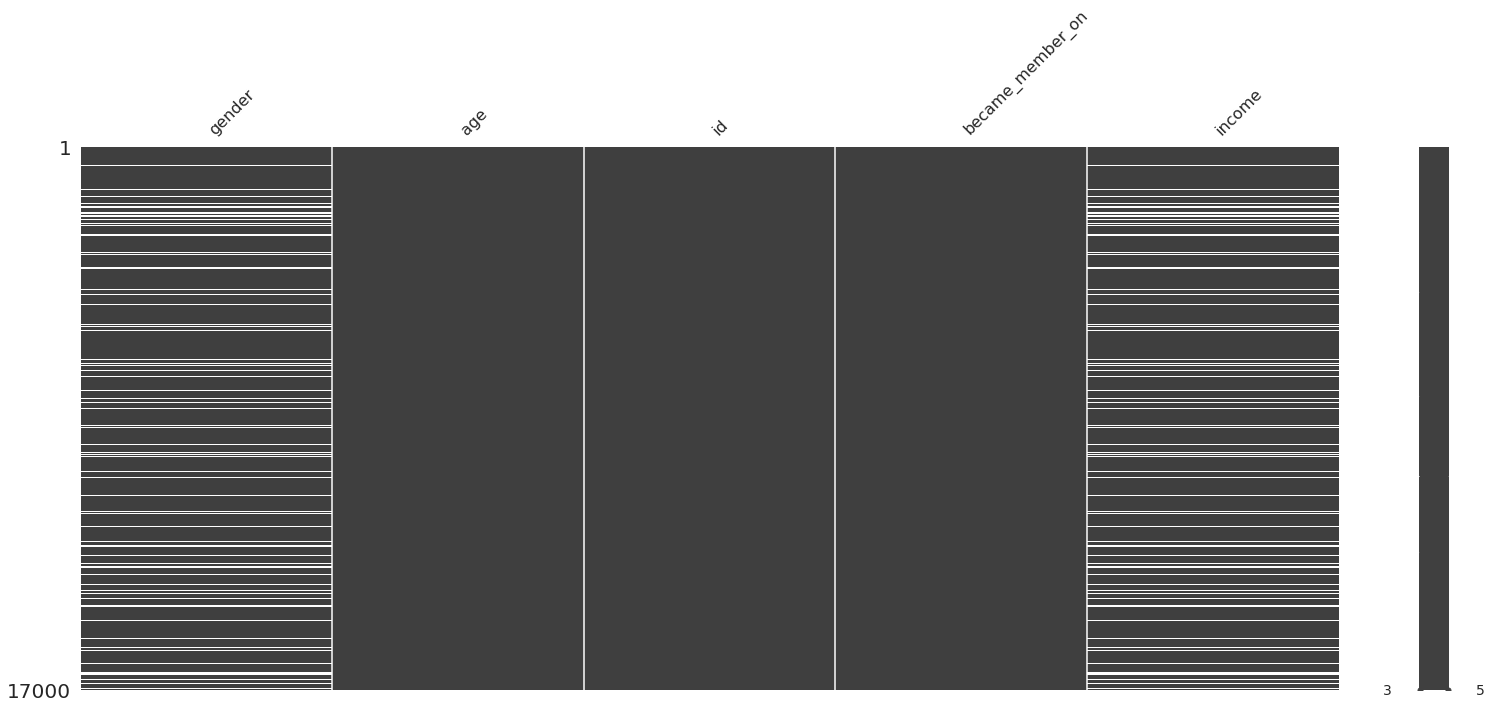

In [21]:
msno.matrix(df_profile)

#### Age 
All age values = 118 are from null profile values

<AxesSubplot:>

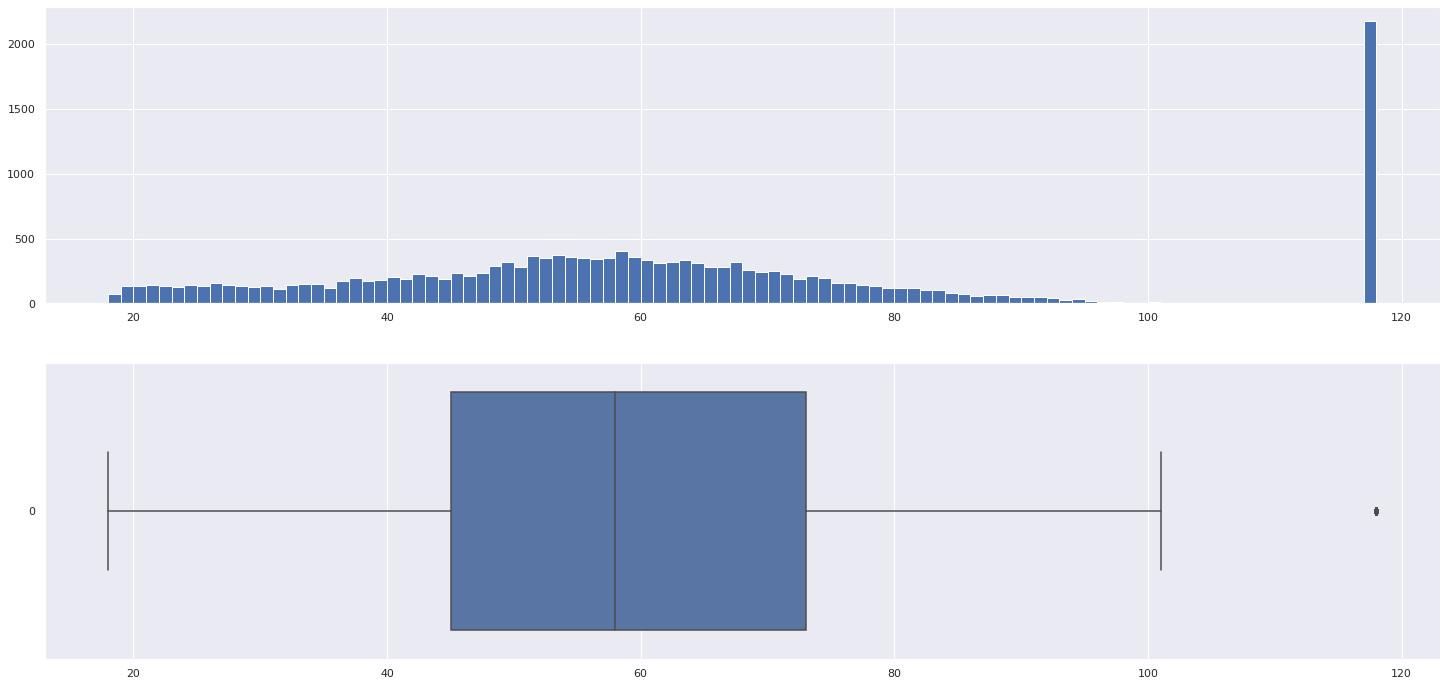

In [27]:
grid = plt.GridSpec(2, 1)

plt.subplot(grid[0, 0])
df_profile['age'].hist(bins=100)

plt.subplot(grid[1, 0])
sns.boxplot(data=df_profile['age'], orient='h')

In [28]:
df_profile.loc[df_profile['age'] == 118, 'age'] = np.nan

#### Gender
Only categorical data will be treated at that time. Continuous data will be handled during the model to avoid data leakage.
Missing data will be replaced by **unknown**.

In [29]:
df_profile['gender'] = df_profile['gender'].fillna('unknown')

### 2.2.3. dtypes

In [30]:
df_profile.dtypes

gender                      object
age                        float64
id                          object
became_member_on    datetime64[ns]
income                     float64
dtype: object

## 2.3. Transcript

In [33]:
df_transcript = transcript.copy()
df_transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [34]:
print(f'Number of rows: {df_transcript.shape[0]}')
print(f'Number of columns: {df_transcript.shape[1]}')

Number of rows: 306534
Number of columns: 4


### 2.3.1. Transform Columns 

In [35]:
clean_value = (
    lambda x: str(x.values())
    .split('[')[1] #split per "[" and get second value
    .split(']')[0] #split per "]" and get first value
    .split(',')[0] #split per "," and get first value
    .strip("'") #taking "'" from values
) 

aux = df_transcript['value'].apply(clean_value)

df_transcript = transcript.assign(value=aux)

df_transcript = df_transcript.assign(code=df_transcript['value']).reset_index(drop=True)

df_transcript['value'] = df_transcript['value'].apply(lambda x: None if '.' not in x else x).astype('float')

In [36]:
join_portfolio = df_portfolio.loc[:, ['id', 'offer_type', 'duration']]

In [37]:
df_transcript = pd.merge(df_transcript, join_portfolio, left_on='code', right_on='id', how='outer').drop('id', axis=1)

# Ordering by person and time
df_transcript = df_transcript.sort_values(['person', 'time'])

# clean code
df_transcript['code'] = df_transcript['code'].apply(lambda x: None if '.' in x else x)

In [38]:
df_transcript['duration'] = df_transcript.loc[df_transcript['event'] == 'offer received', 'duration'] * 24

In [39]:
df_transcript.head()

,person,event,value,time,code,offer_type,duration
155971,0009655768c64bdeb2e877511632db8f,offer received,NaN,168,5a8bc65990b245e5a138643cd4eb9837,informational,72.0
157631,0009655768c64bdeb2e877511632db8f,offer viewed,NaN,192,5a8bc65990b245e5a138643cd4eb9837,informational,NaN
269631,0009655768c64bdeb2e877511632db8f,transaction,22.16,228,None,NaN,NaN
127775,0009655768c64bdeb2e877511632db8f,offer received,NaN,336,3f207df678b143eea3cee63160fa8bed,informational,96.0
129199,0009655768c64bdeb2e877511632db8f,offer viewed,NaN,372,3f207df678b143eea3cee63160fa8bed,informational,NaN


### 2.3.2. Na Values

In [40]:
df_transcript.isnull().sum() / len(df_transcript)

person        0.000000
event         0.000000
value         0.546696
time          0.000000
code          0.453304
offer_type    0.453304
duration      0.751163
dtype: float64

### 2.3.3. dtypes

In [41]:
df_transcript.dtypes

person         object
event          object
value         float64
time            int64
code           object
offer_type     object
duration      float64
dtype: object

# 3.0. Feature Engineering

In [42]:
aux_transcript = df_transcript.loc[df_transcript['offer_type'] != 'informational']

In [43]:
def pivot_transactions(df):
    """
    """
    df = df.loc[
        (df['event'] == 'offer received')
        | (df['event'] == 'offer completed')
        | (df['event'] == 'offer viewed')
        , ['person', 'code', 'event']
    ]

    df['counter'] = 1
    
    aux = df.pivot_table(values='counter', index=['person', 'code'], 
                         columns='event', aggfunc=sum).reset_index()
    aux.columns = ['person', 'code', 'offer_completed', 
                   'offer_received', 'offer_viewed']
    
    aux.fillna(0, inplace=True)

    aux['offer_completed'] = aux['offer_completed'].astype(int)
    aux['offer_received'] = aux['offer_received'].astype(int)
    aux['offer_viewed'] = aux['offer_viewed'].astype(int)
    
    c = 0
    aux_2 = aux.loc[aux['offer_received'] > 1]

    dict_rows = {}
    for index, row in aux_2.iterrows():
        num_rec = row['offer_received']
        for count in range(1, num_rec):
            c += 1
            dict_rows[c] = [row['person'], row['code'], 
                            row['offer_completed'] - count,
                            row['offer_received'],
                            row['offer_viewed'] - count]
            
    append_rows = pd.DataFrame(dict_rows).T
    append_rows.columns = ['person', 'code', 'offer_completed', 'offer_received', 'offer_viewed']
    
    aux = pd.concat([aux, append_rows])
    
    list_columns = ['offer_completed', 'offer_received', 'offer_viewed']
    for column in list_columns:
        aux[column] = aux[column].apply(lambda x: 0 if x <= 0 else 1)
        
    return aux.sort_values(by=['person', 'code'])

## 3.1. Join

In [44]:
df = pivot_transactions(aux_transcript)

In [45]:
df = pd.merge(df, df_profile, left_on='person', right_on='id')
df = pd.merge(df, df_portfolio, left_on='code', right_on='id')

In [46]:
df = df[['person', 'age', 'gender', 'income', 'became_member_on',
         'code', 'offer_type', 'reward', 'duration', 'difficulty', 
         'c_web', 'c_email', 'c_mobile', 'c_social', 'offer_received', 
         'offer_viewed', 'offer_completed']]

## 3.3. Missing Data
Null values ​​are the result of entries without information in the profile. I will create a new column that determines if the value is null or not

In [47]:
df['missing_profile'] = df['income'].apply(lambda x: 1 if pd.isnull(x) else 0)

## 3.4. Response Variable - Completed offer consciously
Not all completed offers are made knowingly. Completed unseen offers should not be considered a success.

In [48]:
df['consciously_complete'] = [1 if (row['offer_viewed'] == 1 & row['offer_completed'] == 1) else 0
                             for index, row in df.iterrows()]

# 4.0. Exploratory Data Analysis

In [49]:
df4 = df.copy()

## 4.1. Univariate Analysis

### 4.1.1. Numerical Variables

#### Profile

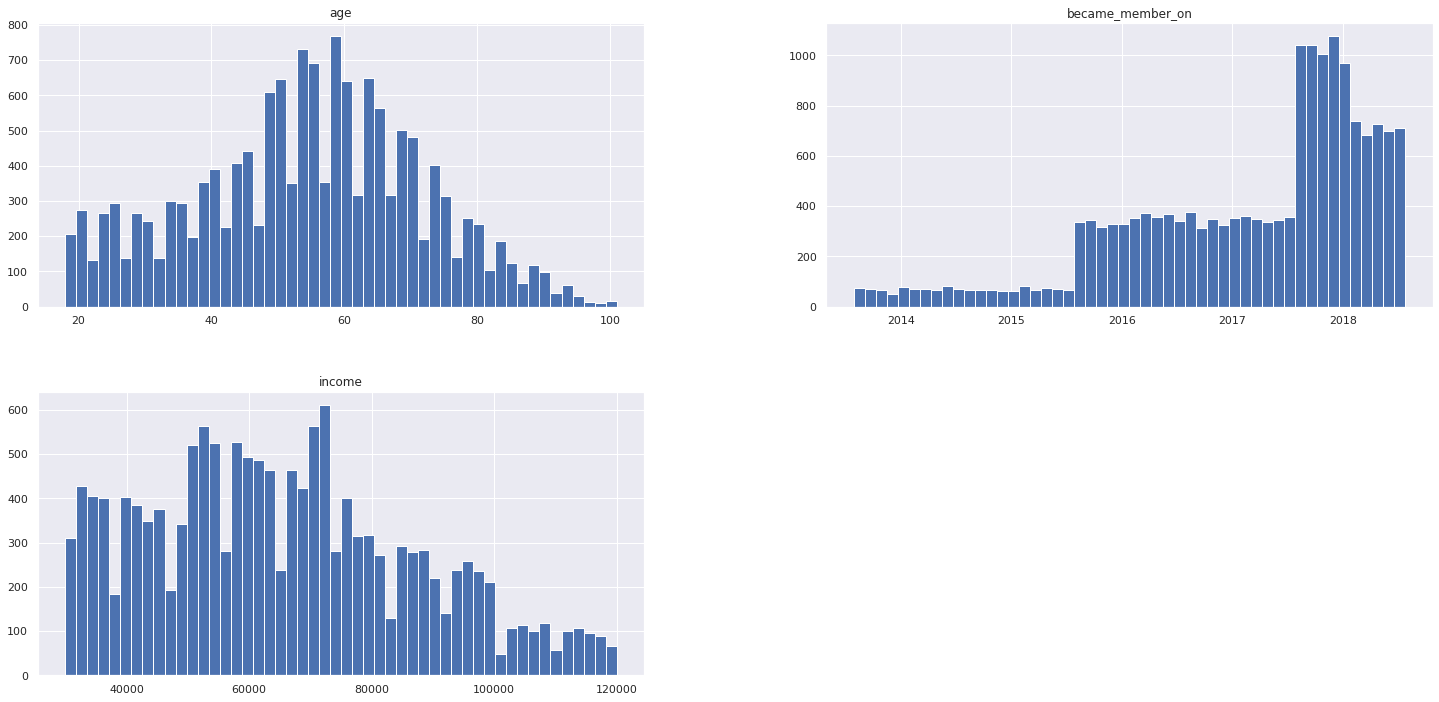

In [50]:
df_profile.hist(bins=50);

In [51]:
df_profile.describe()

,age,income
count,14825.000000,14825.000000
mean,54.393524,65404.991568
std,17.383705,21598.299410
min,18.000000,30000.000000
25%,42.000000,49000.000000
50%,55.000000,64000.000000
75%,66.000000,80000.000000
max,101.000000,120000.000000


#### Transaction

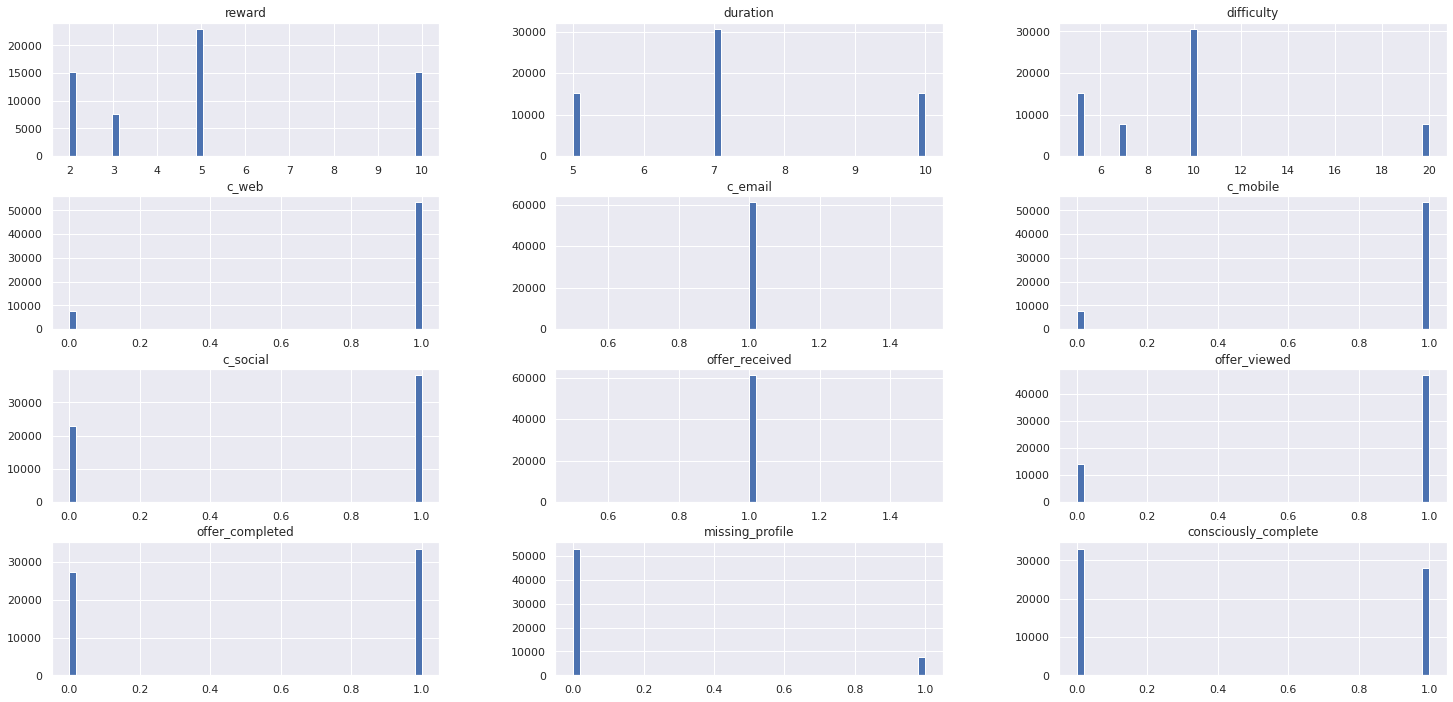

In [53]:
df4.drop(['age', 'income', 'became_member_on'], axis=1).hist(bins=50);

In [54]:
df4.drop(['age', 'income', 'became_member_on'], axis=1).describe()

,reward,duration,difficulty,c_web,c_email,c_mobile,c_social,offer_received,offer_viewed,offer_completed,missing_profile,consciously_complete
count,61042.000000,61042.000000,61042.000000,61042.000000,61042.0,61042.000000,61042.000000,61042.0,61042.000000,61042.000000,61042.000000,61042.000000
mean,5.250254,7.253383,9.631434,0.874545,1.0,0.874382,0.623587,1.0,0.768225,0.550097,0.128453,0.457881
std,2.988313,1.783308,4.449554,0.331236,0.0,0.331422,0.484490,0.0,0.421969,0.497488,0.334596,0.498227
min,2.000000,5.000000,5.000000,0.000000,1.0,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000
25%,3.000000,7.000000,7.000000,1.000000,1.0,1.000000,0.000000,1.0,1.000000,0.000000,0.000000,0.000000
50%,5.000000,7.000000,10.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,0.000000,0.000000
75%,5.000000,10.000000,10.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,0.000000,1.000000
max,10.000000,10.000000,20.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000
